In [12]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import Estimate

from LimitedCommitmentModel import LimitedCommitmentModelClass

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)


plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

SAVE = False

# c++ settings
do_compile = True
threads = 7

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Solve the model

In [13]:
# compile c++ files
T = 7
specs = {  
    #'model FC, NO_HK ':{'latexname':'limited', 'par':{ 'T':T,'do_HK': False, 'threads':threads,'bargaining':0}},
    'model LC, NO_HK ':{'latexname':'limited', 'par':{ 'T':T,'do_HK': False, 'threads':threads,'bargaining':1}},
    #'model NC, NO_HK ':{'latexname':'limited', 'par':{ 'T':T,'do_HK': False, 'threads':threads,'bargaining':2}},
    #'model FC, HK ':{'latexname':'limited', 'par':{ 'T':T,'do_HK': True, 'threads':threads,'bargaining':0}},
    'model LC, HK ':{'latexname':'limited', 'par':{ 'T':T,'do_HK': True, 'threads':threads,'bargaining':1}},
    #'model NC, HK ':{'latexname':'limited', 'par':{ 'T':T,'do_HK': True, 'threads':threads,'bargaining':2}},

}




# solve different models
models = {}
for m,(name,spec) in enumerate(specs.items()):
    print(f'{name} loading...',end='')
    
    # setup model
    models[name] = LimitedCommitmentModelClass(name=name,par=spec['par'])
    models[name].spec = spec

    compile_now = True if do_compile & (m==0) else False
    models[name].link_to_cpp(force_compile=compile_now)
    
    print(' solving...')
    %time models[name].solve() 

model LC, NO_HK  loading... solving...
CPU times: total: 35min 4s
Wall time: 6min 46s


In [15]:


model = models['model LC, HK ']
model.sim.init_love[:] =0.2
model.simulate()
print('HK')
print(f'Couple {np.mean(model.sim.couple,0)}')

print(f'Laborw {np.mean(model.sim.labor_w,0)}')
print(f'Laborm {np.mean(model.sim.labor_m,0)}')
print(f'Consumption W {np.mean(model.sim.cons_w,0)}')
print(f'Consumption M {np.mean(model.sim.cons_m,0)}')
print(f'Asset {np.nanmean(model.sim.A,0)}')
print(f'HKw {np.mean(model.sim.Kw,0)}')
print(f'HKm {np.mean(model.sim.Km,0)}')
temp = model.sim.power
I = model.sim.couple<1
nan = np.zeros(I.shape)
nan[I] = np.nan
temp = np.nanmean(temp + nan,axis=0)
print(f'Power {temp}')



model = models['model LC, NO_HK ']
model.sim.init_love[:] =0.2
model.simulate()
print('NO hk')
print(f'Couple {np.mean(model.sim.couple,0)}')

print(f'Laborw {np.mean(model.sim.labor_w,0)}')
print(f'Laborm {np.mean(model.sim.labor_m,0)}')
print(f'Consumption W {np.mean(model.sim.cons_w,0)}')
print(f'Consumption M {np.mean(model.sim.cons_m,0)}')
print(f'Asset {np.nanmean(model.sim.A,0)}')
print(f'HKw {np.mean(model.sim.Kw,0)}')
print(f'HKm {np.mean(model.sim.Km,0)}')
temp = model.sim.power
I = model.sim.couple<1
nan = np.zeros(I.shape)
nan[I] = np.nan
temp = np.nanmean(temp + nan,axis=0)
print(f'Power {temp}')




NO hk
Couple [1.      0.79576 0.66426 0.58592 0.54034]
Laborw [0.80285825 0.75908373 0.73982715 0.71683965 0.69436499]
Laborm [0.81047419 0.76129383 0.74460106 0.72445328 0.70204917]
Consumption W [4.22562779 4.35508936 4.51919755 4.7399715  5.00934313]
Consumption M [4.22562779 4.36721226 4.58408138 4.88140582 5.24311384]
Asset [0.33428638 0.19526254 0.13234275 0.09328684 0.        ]
HKw [1.00041517 0.70017928 1.40019631 2.10100435 2.79973653]
HKm [1.00124907 0.69965892 1.40117381 2.10000628 2.79911115]
Power [0.49379621 0.49361637 0.49346839 0.49325495 0.4927657 ]


0.4348962122573108
3.647773158274037
[0.43578756 0.43578756 0.43578756 0.43578756 0.43578756]
4.676648089322076
3.0980055379888762
[ 0.50564905  0.50564905 -1.         -1.         -1.        ]
power mean [0.43697756 0.33349657 0.21061229 0.10670032 0.02022937]
power min [-1. -1. -1. -1. -1.]
power max [0.69643226 0.69391727 0.6930844  0.69088979 0.69088979]
Kw [9.99963906 1.5105079  1.49116212 1.53380463 1.51936035]
[False  True False ... False  True  True]


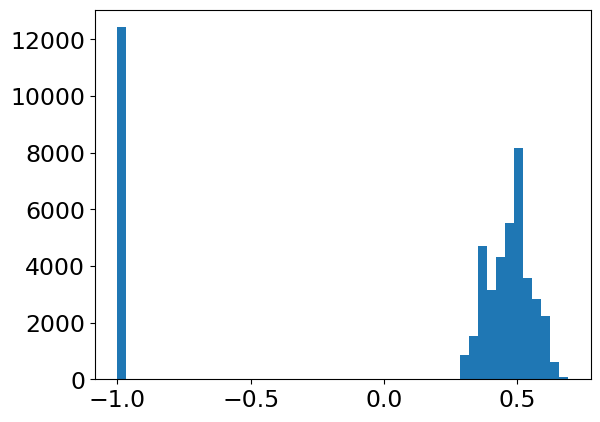

[[ 0.40964658 -0.01054872]
 [-0.01054872  0.25000499]]


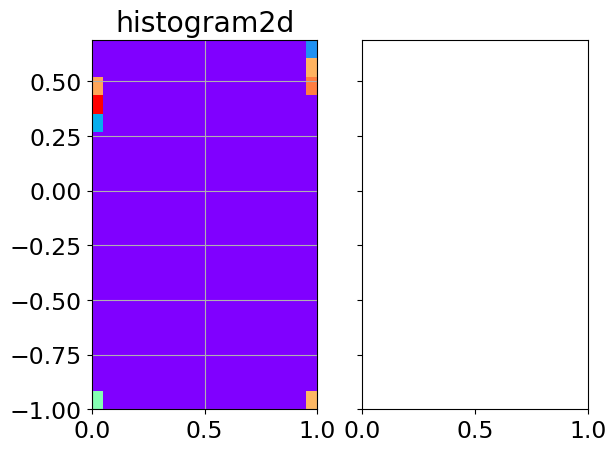

In [85]:

i = 10
print(model.sim.init_Kw[i])
print(model.sim.init_Km[i])
print(model.sim.power[i,:])



i = 1
print(model.sim.init_Kw[i])
print(model.sim.init_Km[i])
print(model.sim.power[i,:])



t = 3
print(f'power mean {np.mean(model.sim.power,0)}')
print(f'power min {np.min(model.sim.power,0)}')
print(f'power max {np.max(model.sim.power,0)}')
print(f'Kw {np.max(model.sim.Kw,0)}')

init_barg = model.sim.init_Kw > model.sim.init_Km
print(init_barg)
plt.hist(model.sim.power[:,t], bins = 50 )
plt.show()

print(np.cov(model.sim.power[:,t],init_barg))
H, yedges, xedges = np.histogram2d(model.sim.power[:,t], init_barg, bins=20)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.pcolormesh(xedges, yedges, H, cmap='rainbow')
ax1.set_title('histogram2d')
ax1.grid()
plt.show()

0.11111111111111116
[-3.74029616 -3.72084414 -3.70210979 -3.68381645 -3.66557745 -3.64746332
 -3.62940254 -3.61144487 -3.59350756 -3.57562308 -3.55774844 -3.53994267
 -3.52214625 -3.50437634 -3.48661978 -3.46887355 -3.45115152 -3.43343923
 -3.41573177 -3.39800513 -3.38030404 -3.36254443 -3.34483673 -3.32706995
 -3.30928211 -3.2914634  -3.27360149 -3.2557045  -3.23773283 -3.21971997
 -3.20162102 -3.18343363 -3.16512936 -3.14674613 -3.12819993 -3.10954189
 -3.09068998 -3.07165842 -3.05241692 -3.03292448 -3.01314279 -2.99302382
 -2.97251347 -2.95154516 -2.92999995 -2.90775558 -2.88461813 -2.86026853
 -2.83417936 -2.80502949]
[0.71948123 0.71018906 0.70093319 0.69171423 0.68253301 0.67621653
 0.67333267 0.6692454  0.66425181 0.66157925 0.65711072 0.65235114
 0.65156124 0.64770182 0.64438444 0.64191681 0.63884668 0.6371435
 0.63478255 0.63203819 0.62863636 0.62539378 0.62223028 0.62108188
 0.6185309  0.61562728 0.61319729 0.60955501 0.60665972 0.60422829
 0.60089497 0.59824193 0.6184312  0.

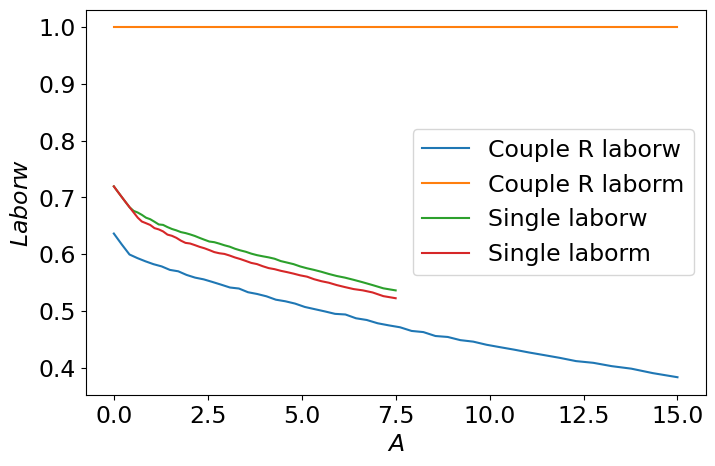

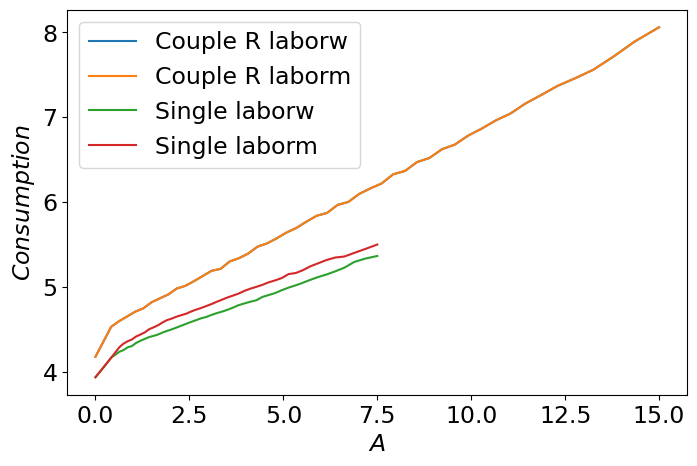

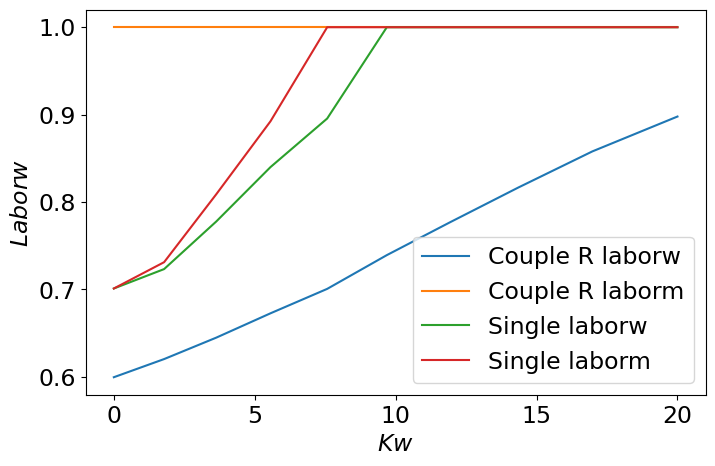

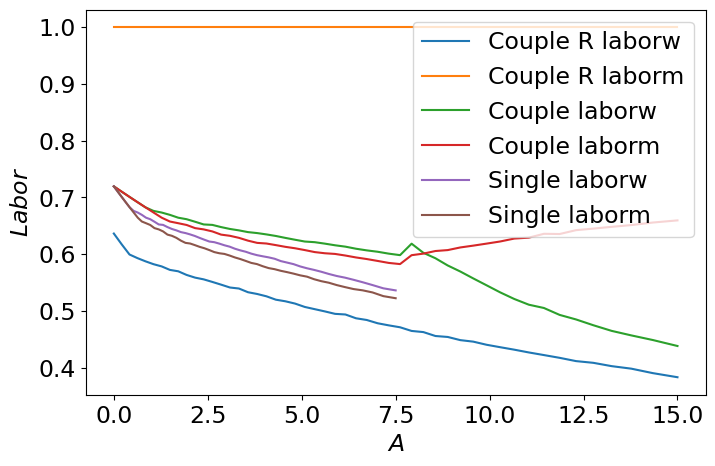

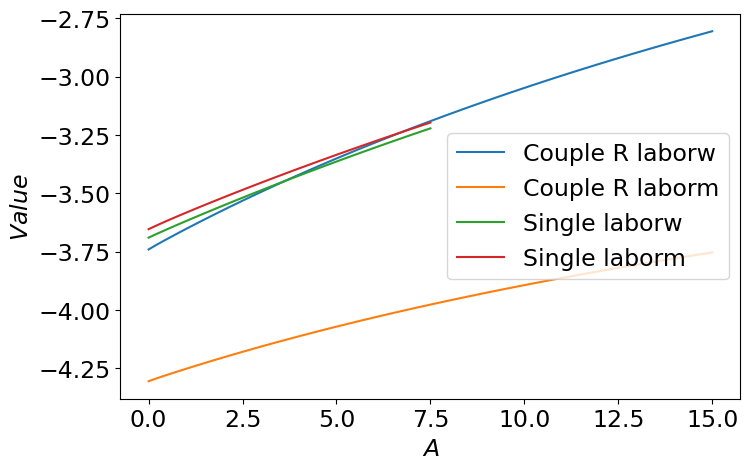

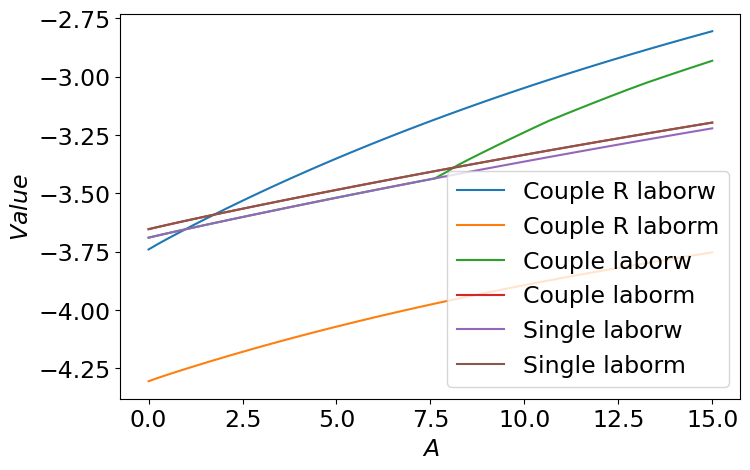

In [73]:
i_P = 20
#i_P = 8
i_A = 2
i_L = 5
i_t = 1
i_HKw = 0
i_HKm = 0
t = i_t


#sol = models['model 2'].sol
#par = models['model 2'].par


#print(sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm])

#print(sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])

#print(sol.labor_w_single[t,:,i_HKm])


sol = models['model 2'].sol
par = models['model 2'].par
print(par.grid_love[i_L])

print(sol.Vw_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])


print(sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm])

print(sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])

print(sol.labor_w_single[t,:,i_HKw])
print(sol.labor_m_single[t,:,i_HKw])


print(sol.Vw_single[t,:,i_HKw])




fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.labor_m_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_Aw,sol.labor_w_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_Am,sol.labor_m_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.cons_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.cons_m_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_Aw,sol.cons_w_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_Am,sol.cons_m_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Consumption$")
plt.legend()
plt.show()




fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.labor_w_remain_couple[t,i_P,i_L,i_A,:,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_K,sol.labor_m_remain_couple[t,i_P,i_L,i_A,:,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_K,sol.labor_w_single[t,i_A,:], label = 'Single laborw')
ax.plot(par.grid_K,sol.labor_m_single[t,i_A,:], label = 'Single laborm')                      
ax.set_xlabel(f"$Kw$")
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()



fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.labor_m_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_A,sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborw')
ax.plot(par.grid_A,sol.labor_m_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborm')
ax.plot(par.grid_Aw,sol.labor_w_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_Am,sol.labor_m_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Labor$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.Vw_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.Vm_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_Aw,sol.Vw_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_Am,sol.Vm_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.Vw_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.Vm_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_A,sol.Vw_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborw')
ax.plot(par.grid_A,sol.Vm_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborm')
ax.plot(par.grid_A,sol.Vw_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_A,sol.Vm_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()



[0.77573385 0.76708343 0.75847147 0.74769378 0.74634325 0.73833722
 0.73228916 0.73025473 0.72299466 0.72149266 0.71502512 0.71188288
 0.71049813 0.70688407 0.70342436 0.69952258 0.69751168 0.69403447
 0.69275464 0.68981268 0.68678379 0.68389904 0.68203576 0.68030684
 0.67808376 0.6757682  0.67375205 0.67090799 0.66900451 0.66701767
 0.66515895 0.66326437 0.66129527 0.65920695 0.65726709 0.65557059
 0.65361046 0.65192571 0.65016706 0.64783097 0.64606293 0.64427117
 0.64247925 0.64080456 0.63878772 0.63636088 0.63451967 0.63253103
 0.6294066  0.62745686]


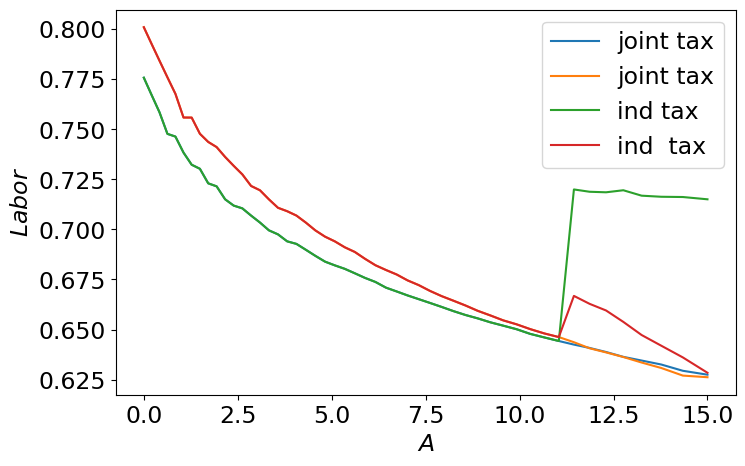

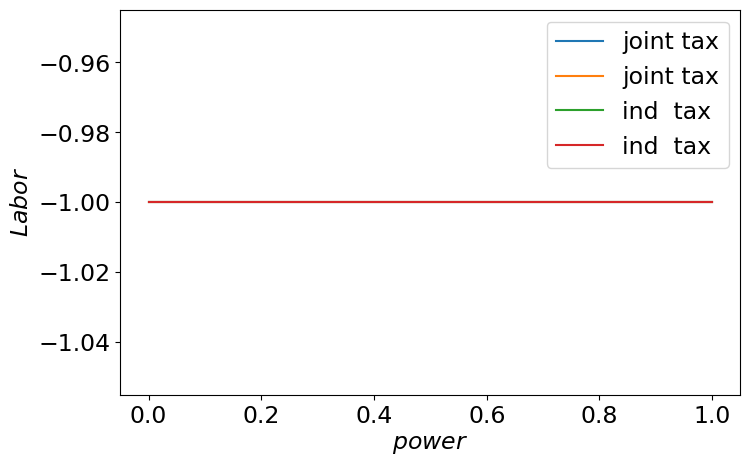

In [179]:

sol2 = models['model 2'].sol
sol1 = models['model 1'].sol
par = models['model 2'].par

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

print(sol1.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm])
ax.plot(par.grid_A,sol1.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'joint tax')
ax.plot(par.grid_A,sol1.labor_m_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'joint tax')
ax.plot(par.grid_A,sol2.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'ind tax')
ax.plot(par.grid_A,sol2.labor_m_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'ind  tax')                 
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Labor$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_power,sol1.power[t,:,i_L,i_A,i_HKw,i_HKm], label = 'joint tax')
ax.plot(par.grid_power,sol1.power[t,:,i_L,i_A,i_HKw,i_HKm], label = 'joint tax')
ax.plot(par.grid_power,sol2.power[t,:,i_L,i_A,i_HKw,i_HKm], label = 'ind  tax')
ax.plot(par.grid_power,sol2.power[t,:,i_L,i_A,i_HKw,i_HKm], label = 'ind  tax')                 
ax.set_xlabel(f"$power$")
ax.set_ylabel(f"$Labor$")
plt.legend()
plt.show()

# Estimate the model

In [254]:
#Save the data 
model = models['model 1']
model.sim.init_love[:] =0.2
np.random.seed(model.par.seed)
data1 = Estimate.create_data(model,start_p = 2, end_p = 7, to_xl = True, name_xl = 'simulated_data_full_commitment')
model = models['model 2']
model.sim.init_love[:] =0.2
np.random.seed(model.par.seed)
data2 = Estimate.create_data(model,start_p = 2, end_p = 7, to_xl = True, name_xl = 'simulated_data_limm_commitment')
model = models['model 3']
model.sim.init_love[:] =0.2
np.random.seed(model.par.seed)
data3 = Estimate.create_data(model,start_p = 2, end_p = 7, to_xl = True, name_xl = 'simulated_data_no_commitment')


c:\Users\czk481\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:

#Estimate the model one time
data_reg = Estimate.aux_est(data2,print_reg=True)
data_reg, Wald_FC, Wald_NC = Estimate.main_est(data_reg,print_reg=True) 